# Notebook to analyse the obtained results

In [1]:
import pandas as pd
import os

def load() -> pd.DataFrame:
    path = os.getcwd() + "/parallel_shortest_path/data/"

    ds_names_list: list[str] = ["results_200.csv", "results_500.csv", "results_1000.csv", "results_2500.csv", "results_5000.csv", "results_7500.csv", "results_10000.csv"]

    df_list: list[pd.DataFrame] = []

    for ds_name in ds_names_list:
        df: pd.DataFrame = pd.read_csv(path + ds_name)

        df_list.append(df)

    data: pd.DataFrame = pd.concat(df_list, axis=0, ignore_index=True)
    data = data.groupby(['algorithm', 'parallel', 'delta', 'graph_size', 'graph_density', 'n_threads'], as_index=False).mean().drop(columns=['n_repeat'])

    return data

data = load()

In [2]:
class Algorithm:
    fwd = {
        0:"DeltaStepping",
        1: "DijkstraSequential", 
        2: "ParallelDeltaStepping"
        }
    bwd = {v: k for k, v in fwd.items()}
    def __getitem__(self, item):
        if type(item) == str:
            return self.bwd[item]
        elif type(item) == int:
            return self.fwd[item]

    def __iter__(self):
        return self.fwd.__iter__()

def filter_df(df, alg:str | int = None, parallel:bool = None, delta:int = None, graph_size:int = None, graph_density:float = None, n_threads:int = None):
    df = df.copy()
    if alg is not None:
        df = df[(df['algorithm'] == Algorithm()[alg])]
    if parallel is not None:
        df = df[df['parallel'] == int(parallel)]
    if delta is not None:
        df = df[df['delta'] == delta]
    if graph_size is not None:
        df = df[df['graph_size'] == graph_size]
    if graph_density is not None:
        df = df[df['graph_density'] == graph_density]
    if n_threads is not None:
        df = df[df['n_threads'] == n_threads]
    return df

filter_df(data, alg=2, delta=1, graph_size=200, graph_density=0.3)

,algorithm,parallel,delta,graph_size,graph_density,n_threads,time
126,ParallelDeltaStepping,1,1,200,0.3,2,0.234667
127,ParallelDeltaStepping,1,1,200,0.3,4,0.229333
128,ParallelDeltaStepping,1,1,200,0.3,8,0.236000
129,ParallelDeltaStepping,1,1,200,0.3,12,0.231667
130,ParallelDeltaStepping,1,1,200,0.3,16,0.238000
131,ParallelDeltaStepping,1,1,200,0.3,20,0.234000
132,ParallelDeltaStepping,1,1,200,0.3,24,0.315667
133,ParallelDeltaStepping,1,1,200,0.3,25,0.269667


## 3D plot of Dijkstra's on Multiple Graphs

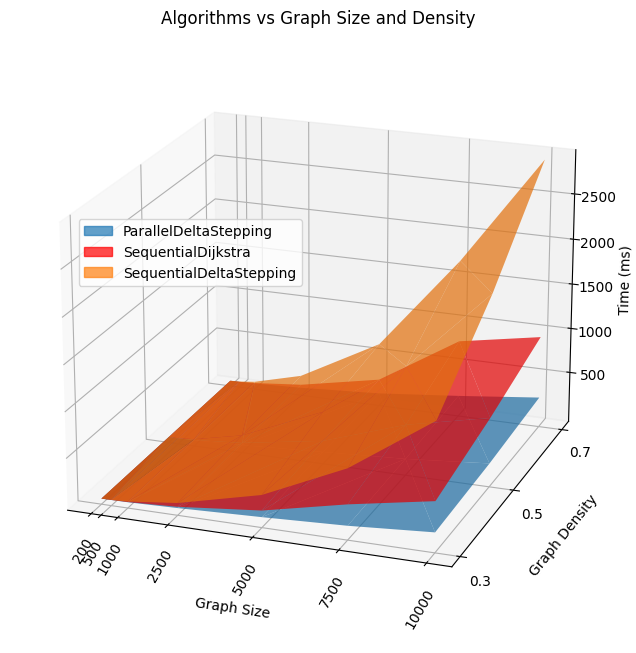

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X = data['graph_size'].unique()
Y = data['graph_density'].unique()

Z = []
W = []
V = []

for x in X:
    for y in Y:
        filtered_df = filter_df(data, alg=0, graph_size=x, graph_density=y,delta=1)
        V.append(float(filtered_df["time"]))
        filtered_df = filter_df(data, alg=1, graph_size=x, graph_density=y)
        Z.append(float(filtered_df["time"]))
        filtered_df = filter_df(data, alg=2, graph_size=x, graph_density=y,delta=1, n_threads=4)
        W.append(float(filtered_df["time"]))

zz = np.linspace(200, 10000, 100)

Z = np.array(Z).reshape(len(X), len(Y))
W = np.array(W).reshape(len(X), len(Y))
V = np.array(V).reshape(len(X), len(Y))

X, Y = np.meshgrid(X, Y)

ax.view_init(elev=20, azim=290)  # change these values as needed
ax.plot_trisurf(X.flatten(), Y.flatten(), Z.T.flatten(), alpha=0.7, color='r', label='DijkstraSequential')
ax.plot_trisurf(X.flatten(), Y.flatten(), W.T.flatten(), alpha=0.7, color='C0', label='ParallelDeltaStepping')
ax.plot_trisurf(X.flatten(), Y.flatten(), V.T.flatten(), alpha=0.7, color='C1', label='DeltaStepping')

plt.xticks(data['graph_size'].unique(), rotation=60)
plt.yticks(data['graph_density'].unique())
ax.set_xlabel('Graph Size', labelpad=15)
ax.set_ylabel('Graph Density', labelpad=10)
ax.set_zlabel('Time (ms)', labelpad=5)

red_patch = mpatches.Patch(label='SequentialDijkstra', color="r", alpha=0.7)
blue_patch = mpatches.Patch(label='ParallelDeltaStepping', color="C0", alpha=0.7)
orange_patch = mpatches.Patch(label='SequentialDeltaStepping', color="C1", alpha=0.7)

# upper left shifted down
plt.legend(handles=[blue_patch, red_patch, orange_patch], loc='upper left', bbox_to_anchor=(0.1, 0.7))

plt.title('Algorithms vs Graph Size and Density', pad=-10)

plt.show()


## Dij vs Seq $\Delta$ vs Parallel $\Delta$

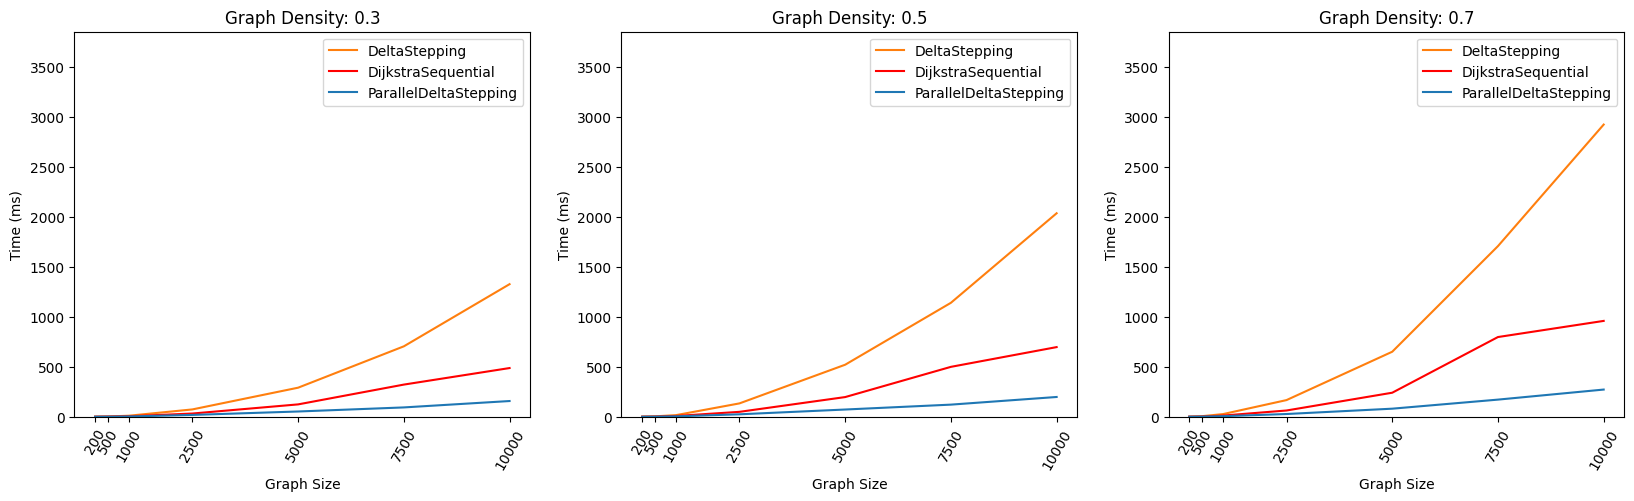

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
delta = 1
n_threads = 4

sizes = data['graph_size'].unique()
densities = data['graph_density'].unique()

for i, density in enumerate(densities):
    filtered_df = filter_df(data, graph_density=density)

    alg = 0 # DeltaStepping
    filtered_df_alg = filter_df(filtered_df, alg=alg, delta=delta)
    axs[i].plot(filtered_df_alg["graph_size"], filtered_df_alg['time'], label=Algorithm()[alg], color="C1")

    alg = 1 # DijkstraSequential
    filtered_df_alg = filter_df(filtered_df, alg=alg)
    axs[i].plot(filtered_df_alg["graph_size"], filtered_df_alg['time'], label=Algorithm()[alg], color="r")
    
    alg = 2 # ParallelDeltaStepping
    filtered_df_alg = filter_df(filtered_df, alg=alg, n_threads=n_threads, delta=delta)
    axs[i].plot(filtered_df_alg["graph_size"], filtered_df_alg['time'], label=Algorithm()[alg], color="C0")

    axs[i].set_xticks(sizes)
    axs[i].set_xticklabels(['200', '500', '1000', '2500', '5000', '7500', '10000'], rotation=60)
    axs[i].set_ylim(0, data["time"].max())
    axs[i].set_title(f"Graph Density: {density}")
    axs[i].set_xlabel('Graph Size')
    axs[i].set_ylabel('Time (ms)')
    axs[i].legend()

plt.show();
    

## Different Deltas

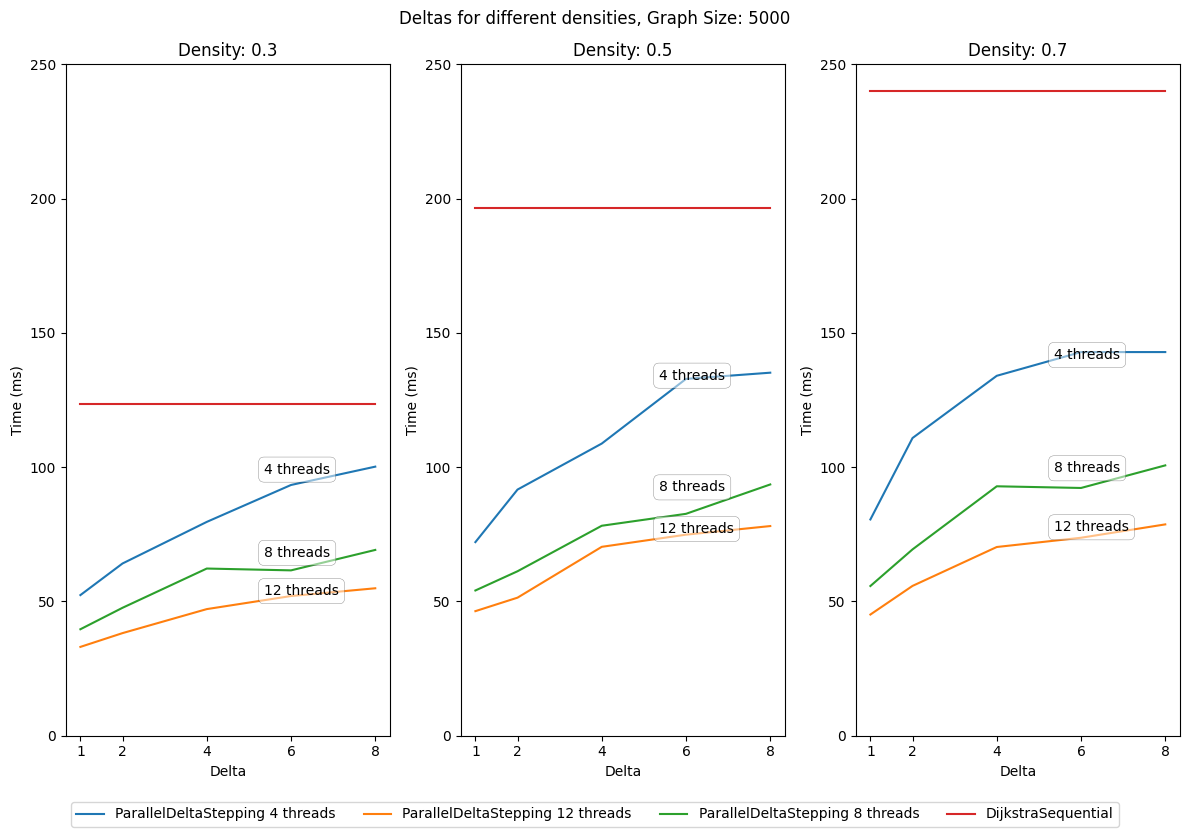

In [5]:
import matplotlib.pyplot as plt
import numpy as np

graph_size = 5000
densities = data["graph_density"].unique()
fig, axs = plt.subplots(1,len(densities), figsize=(12, 8))

lines_labels = []

filtered_df = filter_df(data, graph_size=graph_size, alg=1)
mmin = filtered_df["time"].min()
mmax = filtered_df["time"].max()

for i, density in enumerate(densities):
    filtered_df = filter_df(data, graph_size=graph_size, graph_density=density)

    alg = 1 # DijkstraSequential
    filtered_df_alg = filter_df(filtered_df, alg=alg)
    dijkstra_time = filtered_df_alg["time"].mean()

    alg = 2 # ParallelDeltaStepping
    for n_threads in [4, 12, 8]:
        filtered_df_alg = filter_df(filtered_df, alg=alg, n_threads=n_threads)
        line, = axs[i].plot(filtered_df_alg["delta"], filtered_df_alg['time'], label=f"{Algorithm()[alg]} {n_threads} threads")

        if line.get_label() not in [label for _, label in lines_labels]:
            lines_labels.append((line, line.get_label()))

        axs[i].annotate(f"{n_threads} threads", 
                xy=(filtered_df_alg["delta"].iloc[-1], filtered_df_alg['time'].iloc[-1]), 
                xytext=(-80,-5), textcoords='offset points',
                bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=0.3,alpha=0.5))

    line, = axs[i].plot(filtered_df_alg["delta"], dijkstra_time * np.ones(len(filtered_df_alg["delta"])), label=Algorithm()[1])

    if line.get_label() not in [label for _, label in lines_labels]:
        lines_labels.append((line, line.get_label()))

    axs[i].set_ylim(0, 250)
    axs[i].set_title(f"Density: {density}")
    axs[i].set_xlabel('Delta')
    axs[i].set_xticks(filtered_df_alg["delta"].unique())
    axs[i].set_ylabel('Time (ms)')

plt.suptitle(f"Deltas for different densities, Graph Size: {graph_size}")
plt.tight_layout()

lines, labels = zip(*lines_labels)
fig.legend(lines, labels, loc='lower center', ncol=len(lines), bbox_to_anchor=(0.5, -0.05))

plt.show()

## 3D Plot with $\Delta$ and n_threads as X and Y; and time for Z axis

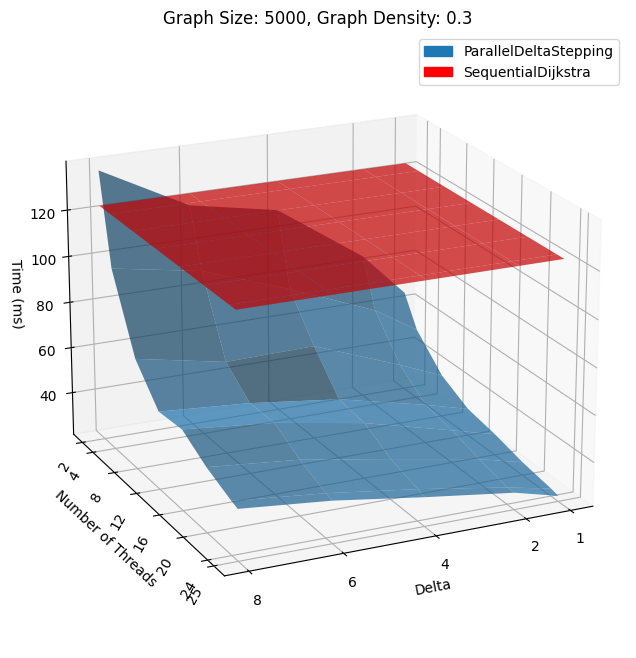

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

graph_size = 5000
graph_density = 0.3

df = filter_df(data, graph_size=graph_size, graph_density=graph_density, alg=2)

X = df['delta'].unique()
X = X[X != -1]
Y = df['n_threads'].unique()
X, Y = np.meshgrid(X, Y)

# DeltaStepping
pivot_table = df.pivot_table(index='n_threads', columns='delta', values='time')
Z = pivot_table.values

#Dijkstra
dijkstra_avg_time = filter_df(data, graph_size=graph_size, graph_density=graph_density, alg=1)["time"]
Z_dijkstra = np.full_like(Z, dijkstra_avg_time)

# Plot
ax.view_init(elev=20, azim=65)  # change these values as needed
ax.plot_surface(X, Y, Z, label="ParallelDeltaStepping", alpha=0.7, color='C0')
ax.plot_surface(X, Y, Z_dijkstra, alpha=0.7, label='SequentialDijkstra', color='r')

# Labels
plt.xlabel('Delta')
plt.xticks(df['delta'].unique())

plt.ylabel('Number of Threads')
plt.yticks(df['n_threads'].unique(),rotation=60)

ax.set_zlabel('Time (ms)')

blue_patch = mpatches.Patch(label='ParallelDeltaStepping', color="C0")
red_patch = mpatches.Patch(label='SequentialDijkstra', color="r")
plt.legend(handles=[blue_patch, red_patch])

plt.title(f'Graph Size: {graph_size}, Graph Density: {graph_density}')
plt.show()